# Определение стоимости автомобилей

В данной работе стоит задача построения модели для определения рыночной стоимости автомобиля для сервиса по продаже автомобилей с пробегом «Не бит, не крашен». Сервис разрабатывает приложение для привлечения новых клиентов, в котором клиент может быстро узнать рыночную стоимость своего автомобиля. В распоряжении имеются исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей будет применяться метрика RMSE. Значение метрики RMSE должно быть меньше 2500.


Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

  Целевой признак

- Price — цена (евро)


## Подготовка данных

Загрузим библиотеки и модули.

In [1]:
!pip install -U scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings('ignore')

### Предобработка данных

Откроем файл и изучим.

In [3]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.shape, data.dtypes

((354369, 16),
 DateCrawled          object
 Price                 int64
 VehicleType          object
 RegistrationYear      int64
 Gearbox              object
 Power                 int64
 Model                object
 Kilometer             int64
 RegistrationMonth     int64
 FuelType             object
 Brand                object
 Repaired             object
 DateCreated          object
 NumberOfPictures      int64
 PostalCode            int64
 LastSeen             object
 dtype: object)

Признаки дат не соответствуют типу, но в обучении модели они участвовать не будут, поэтому менять нет смысла.

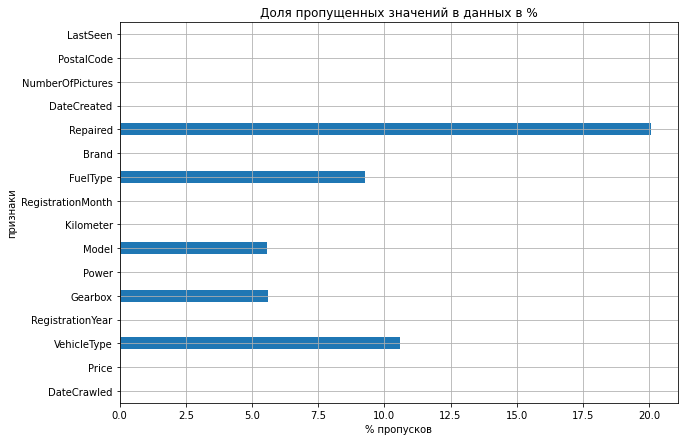

In [5]:
(data.isna().mean() * 100).plot(kind='barh', figsize=(10,7))
plt.grid()
plt.title('Доля пропущенных значений в данных в %')
plt.xlabel('% пропусков')
plt.ylabel('признаки')
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

Есть пропуски в категориальных признаках. Заполним их значением 'unknown'.

In [6]:
cat = ['FuelType', 'VehicleType', 'Gearbox', 'Model', 'Repaired']
data[cat] = data[cat].fillna('unknown')
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Посмотрим на численное описание признаков.

In [7]:
data.describe().style.background_gradient()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.000000,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.000000,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.000000,99998.000000


И на диаграмму размаха.

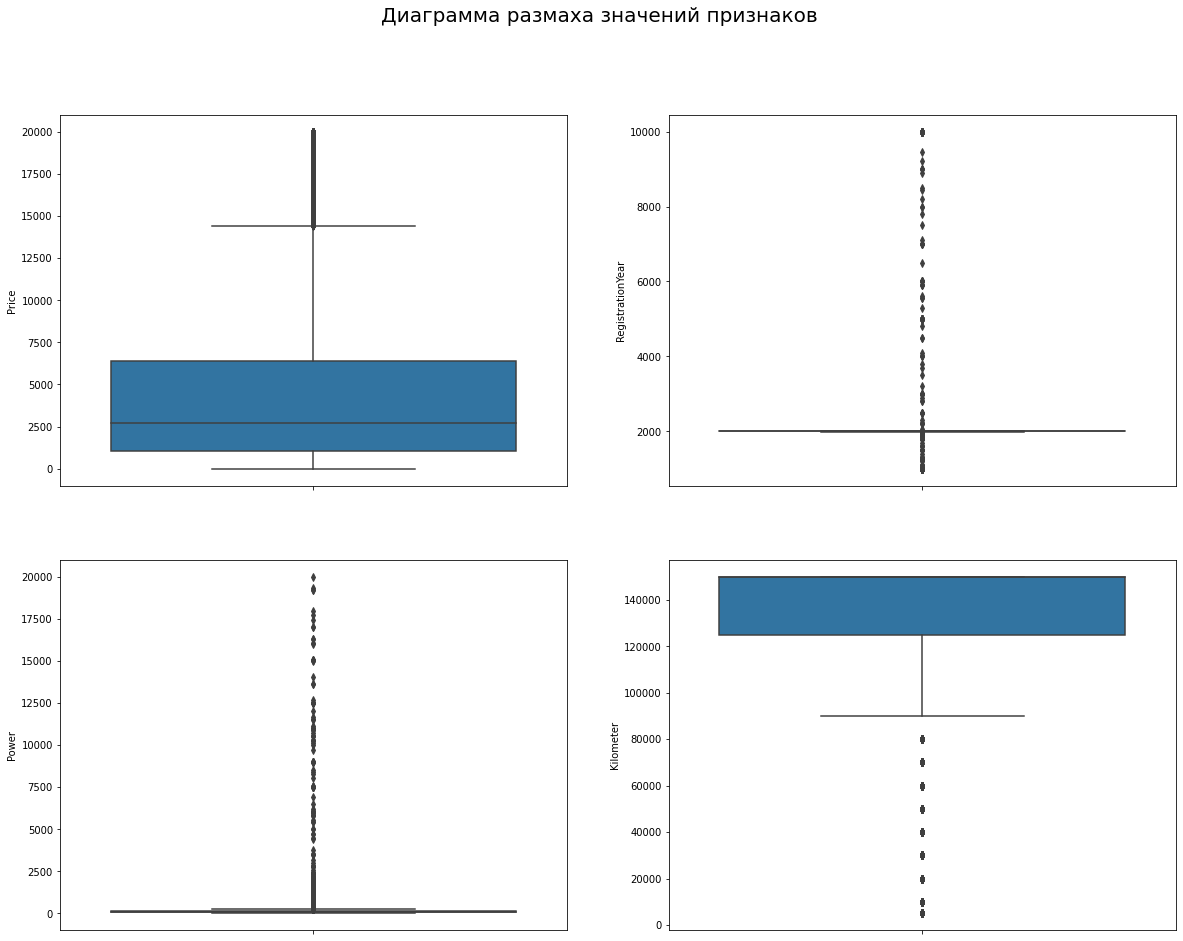

In [8]:
plt.figure(figsize=(20, 15))
plt.title('Диаграмма размаха признаков')
plt.subplot(2,2,1)
sns.boxplot(y=data['Price'])
plt.subplot(2,2,2)
sns.boxplot(y=data['RegistrationYear'])
plt.subplot(2,2,3)
sns.boxplot(y=data['Power'])
plt.subplot(2,2,4)
sns.boxplot(y=data['Kilometer'])
plt.suptitle('Диаграмма размаха значений признаков', fontsize=20)

plt.show()

Есть аномальные значения, которые нужно убрать.

Чтобы синхронизировать верхнюю границу года регистрации с датой выгрузки данных из базы, приведем признак DateCrawled к формату datetime.

In [9]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])

In [10]:
# год регистрации автомобиля зададим в разумных пределах
data = data.loc[(data['RegistrationYear'] <= data['DateCrawled'].dt.year.max()) & (data['RegistrationYear'] > 1990)]

In [11]:
# также мощность автомобиля
data = data.loc[(data['Power'] >= 10) & (data['Power'] < 1300)]

In [12]:
# цена не должна быть равна нулю
data = data.loc[data['Price'] >= 500]

Месяц регистрации трогать не будем, поскольку удаление нулевых значений месяца приведет к значительной потере данных.

In [13]:
# проверим на дубликаты
data.duplicated().sum()

4

In [14]:
# удалим дубликат
data = data.drop_duplicates().reset_index(drop=True)

Удалим неинформативные признаки, не влияющие на стоимость автомобиля.

In [15]:
data = data.drop(['DateCrawled', 'DateCreated',  'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)
data.shape

(271133, 11)

In [16]:
data.duplicated().sum()

22025

In [17]:
# удалим
data = data.drop_duplicates().reset_index(drop=True)

In [18]:
# посмотрим, сколько данных было удалено
df_first = pd.read_csv('/datasets/autos.csv')
rows_before = df_first.shape[0]
rows_after = data.shape[0]
print(f'Данные предобработаны. Было удалено: {round(100 - (rows_after / rows_before * 100), 2)}% данных')

Данные предобработаны. Было удалено: 29.7% данных


### Подготовка выборок.

In [19]:
# разделим данные на обучающую и тестовую выборки

features = data.drop('Price', axis=1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=123)
# проверим размерности
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((186831, 10), (62277, 10), (186831,), (62277,))

In [20]:
# создадим пайплайны с StandardScaler и OneHotEncoder для преобразования категориальных и численных признаков,
# загрузив их в ColumnTransformer

# для численных признаков
std_scaler = StandardScaler()
pipe_num = Pipeline([('scaler', std_scaler)])

# для категориальных
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-99) 
pipe_cat = Pipeline([('encoder', encoder)])

# для линейной регрессии будем использовать OneHotEncoder
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
pipe_cat_ohe = Pipeline([('encoder', encoder_ohe)])

# получаем два варианта ColumnTransformer
# для регрессии
col_transformer_for_lin_model = ColumnTransformer(
    [('num_preproc', pipe_num, [x for x in features.columns if features[x].dtype!='object']),
    ('cat_preproc', pipe_cat_ohe, [x for x in features.columns if features[x].dtype=='object'])])

# для деревьев и бустинга
col_transformer = ColumnTransformer(
    [('num_preproc', pipe_num, [x for x in features.columns if features[x].dtype!='object']),
    ('cat_preproc', pipe_cat, [x for x in features.columns if features[x].dtype=='object'])])

Выборки подготовлены.

## Обучение моделей

Обучим разные модели и подберем наилучшую модель, соответствующую критериям заказчика. Измерим время обучения и предсказания и найдем значение метрики RMSE.

  ### Линейная регрессия.

In [21]:
%%time
model_lr = LinearRegression()
# создадим final_pipe и загрузим в него col_transformer и модель, обучим модель и выведем время обучения
final_pipe_for_lin_model = Pipeline([('preproc', col_transformer_for_lin_model),
                       ('model', model_lr)])
final_pipe_for_lin_model.fit(features_train, target_train)
print('Время обучения линейной регрессии:')

Время обучения линейной регрессии:
CPU times: user 19.2 s, sys: 21.9 s, total: 41.1 s
Wall time: 41.1 s


In [22]:
%%time
# выведем время предсказания на обучающей выборке и значение метрики
predictions = final_pipe_for_lin_model.predict(features_train)

print('Время предсказания линейной регрессии на обучающей выборке: \n')

Время предсказания линейной регрессии на обучающей выборке: 

CPU times: user 373 ms, sys: 36.6 ms, total: 410 ms
Wall time: 418 ms


In [23]:
rmse_lr = cross_val_score(final_pipe_for_lin_model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5).mean()

print('RMSE модели линейной регрессии с кросс-валидации:', round(rmse_lr * (-1), 2))

RMSE модели линейной регрессии с кросс-валидации: 2287.63


### Решающее дерево. 

  Подберем оптимальную глубину решающего дерева, при которой значение RMSE минимально. Используем GridSearchCV.

In [24]:
model_tree = DecisionTreeRegressor()

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_tree)])
# посмотрим на доступные параметры
final_pipe.get_params()

{'memory': None,
 'steps': [('preproc',
   ColumnTransformer(transformers=[('num_preproc',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['RegistrationYear', 'Power', 'Kilometer',
                                     'RegistrationMonth']),
                                   ('cat_preproc',
                                    Pipeline(steps=[('encoder',
                                                     OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                    unknown_value=-99))]),
                                    ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                                     'Brand', 'Repaired'])])),
  ('model', DecisionTreeRegressor())],
 'verbose': False,
 'preproc': ColumnTransformer(transformers=[('num_preproc',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                             

In [25]:
params = {'model__max_depth': [2, 7],
         'model__random_state': [123]}
grid_search = GridSearchCV(estimator=final_pipe, param_grid=params, cv=5, scoring='neg_root_mean_squared_error')

grid_search.fit(features_train, target_train)

print(grid_search.best_params_)
print(round(grid_search.best_score_ * (-1), 3))

{'model__max_depth': 7, 'model__random_state': 123}
2089.572


Наилучшая модель решающего дерева с глубиной 7, значение RMSE на обучающей выборке составляет 2089.572.

In [26]:
%%time
# измерим скорость обучения лучшей модели решающего дерева 
model_tree_best = DecisionTreeRegressor(max_depth=7, random_state=123)
final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_tree_best)])
final_pipe.fit(features_train, target_train)
print('Время обучения лучшей модели решающего дерева:\n')

Время обучения лучшей модели решающего дерева:

CPU times: user 581 ms, sys: 4.38 ms, total: 585 ms
Wall time: 591 ms


In [27]:
%%time
# измерим скорость предсказания лучшей модели решающего дерева
predictions = final_pipe.predict(features_train)
print('Время предсказания лучшей модели решающего дерева на обучающей выборке:\n')

Время предсказания лучшей модели решающего дерева на обучающей выборке:

CPU times: user 238 ms, sys: 1.13 ms, total: 239 ms
Wall time: 247 ms


Значение метрики RMSE для этой модели мы уже нашли.

### Градиентный бустинг LightGBM.

Аналогично найдем наилучшие гиперпараметры модели с помощью GridSearchCV.

In [29]:
model_lgbm = LGBMRegressor()

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_lgbm)])
# посмотрим на доступные параметры
final_pipe.get_params()

{'memory': None,
 'steps': [('preproc',
   ColumnTransformer(transformers=[('num_preproc',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['RegistrationYear', 'Power', 'Kilometer',
                                     'RegistrationMonth']),
                                   ('cat_preproc',
                                    Pipeline(steps=[('encoder',
                                                     OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                    unknown_value=-99))]),
                                    ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                                     'Brand', 'Repaired'])])),
  ('model', LGBMRegressor())],
 'verbose': False,
 'preproc': ColumnTransformer(transformers=[('num_preproc',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['R

In [30]:
params = {'model__num_leaves': [31, 36],
         'model__boosting_type': ['gbdt', 'dart'],
         'model__random_state': [123]}
grid_search = GridSearchCV(estimator=final_pipe, param_grid=params, cv=5, scoring='neg_root_mean_squared_error')

grid_search.fit(features_train, target_train)

print(grid_search.best_params_)
print(round(grid_search.best_score_ * (-1), 3))

{'model__boosting_type': 'gbdt', 'model__num_leaves': 36, 'model__random_state': 123}
1576.129


Лучшая модель LightGBM с типом бустинга gbdt и числом листьев 36. Значение RMSE 1576.129. Измерим скорость обучения и предсказания модели.

In [31]:
%%time
# время обучения. Параметр boosting_type='gbdt' это параметр по умолчанию, поэтому можно его не указывать
model_lgbm_best = LGBMRegressor(num_leaves=36, random_state=123)
final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_lgbm_best)])
final_pipe.fit(features_train, target_train)
print('Время обучения лучшей модели LightGBM:\n')
print('\n')        

Время обучения лучшей модели LightGBM:



CPU times: user 37.3 s, sys: 343 ms, total: 37.7 s
Wall time: 37.9 s


In [32]:
%%time
# время предсказания
predictions = final_pipe.predict(features_train)
print('Время предсказания лучшей модели LightGBM на обучающей выборке:\n')

Время предсказания лучшей модели LightGBM на обучающей выборке:

CPU times: user 1.7 s, sys: 1 ms, total: 1.71 s
Wall time: 1.71 s


## Анализ моделей

Было обучено три модели с измерением времени обучения и предсказания.

- время обучения линейной регрессии 41.1 секунды, предсказания - 418 милисекунд. Значение RMSE, полученное с кросс-валидации: 2287.63.

-  лучшую модель решающего дерева получили, выбрав наименьшее RMSE на кросс-валидации. Это модель с глубиной 7, значение RMSE на обучающей выборке составило 2089.572. Время обучения - 591 милисекунда, предсказания - 247 милисекунд. Модель показала себя лучше модели линейной регрессии. 
  
- лучшую модель LightGBM аналогично искали наименьшим RMSE на кросс-валидации. Это модель с числом листьtd 36 и boosting_type = 'gbdt'. Значение RMSE составило 1576.129. Время обучения - 37.9 секунды, предсказания - 1.71 секунды. Значение метрики существенно лучше предыдущих моделей. 

Таким образом, модель, соответствующая критериям заказчика - это LightGBM.

### Проверка модели на тестовой выборке.

Лучшая модель определена. Проверим ее качество на тестовой выборке.

In [33]:
# параметр boosting_type='gbdt' можно не указывать
model_lgbm_best = LGBMRegressor(num_leaves=36, random_state=123)

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_lgbm_best)])
final_pipe.fit(features_train, target_train)
predictions = final_pipe.predict(features_test)
predictions
rmse_lgbm_best = mean_squared_error(target_test, predictions, squared=False)
print('RMSE лучшей модели LightGBM на тестовой выборке:', round(rmse_lgbm_best, 2))

RMSE лучшей модели LightGBM на тестовой выборке: 1575.49


Также проверим модель на адекватность с помощью DummyRegressor, сравнив значения метрик.

In [34]:
dummy_model = DummyRegressor()
final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', dummy_model)])
# найдем rmse dummy-модели с кросс-валидации
rmse_dummy = cross_val_score(
        final_pipe, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5).mean()        
print(f'Значение rmse dummy-модели с кросс-валидации: {round(rmse_dummy * (-1), 3)}')

Значение rmse dummy-модели с кросс-валидации: 4618.175


Сравнение метрик показало, что модель LightGBM однозначно прошла проверку на адекватность. 

## Общий вывод.

В ходе работы над проектом исходные данные были изучены и предобработаны.

  Были подготовлены выборки для обучения. C помощью пайплайнов преобразовали категориальные признаки и масштабировали численные. 
  
  Лучшие гиперпараметры искали с помощью GridSearchCV и наименьим значением метрики RMSE.
    
  Критериям заказчика (качество предсказания, скорость обучения и предсказания) в данном случае удовлетворяет модель LightGBM (с num_leaves=33). Время обучения - 37.9 секунды, предсказания - 1.71 секунды. Значение RMSE на тестовой выборке составило 1575.49.
  Модель также прошла проверку на адекватность с помощью dummy-модели.